# Making plots using the COSIMA Cookbook

This notebook uses ACCESS-OM2-01 outputs to create some basic plots using the COSIMA Cookbook.


**Requirements:** We strongly suggest that you select the `conda/analysis3-20.01` (or later) kernel.

**Loading relevant libraries**

In [1]:
#Make plots appear in line
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import pandas as pd

Libraries used to make maps

In [2]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps.
import cartopy.feature as cft                     # For adding features to maps

It's often a good idea to start a cluster with multiple cores for you to work with. This is the easiest way to do that:

In [3]:
client = Client(n_workers=4)

Accessing default database of experiments from which data will be loaded.

In [4]:
session = cc.database.create_session()

## Database experiment list
* Accessing list of all experiments including in the database loaded.
* Searching for outputs of the 0.1 degree model 
* Keeping only outputs that include wind forcing identified as *IAF*
* Include latest experiment cycle *jra55v140* - Data from this experiment could not be loaded, so looking for previous run.

In [5]:
#Allowing all elements in the list to show in the console
pd.set_option("display.max_rows", None)

#Extracting the entire list of experiments in the database
explist = cc.querying.get_experiments(session, all = True) #the 2nd argument provides additional info about each experiment

#Searching for experiments that meet the criteria listed above. 
explist[explist['experiment'].str.contains("01deg.*jra55v1.*iaf*")]

,experiment,contact,email,created,description,notes,root_dir,ncfiles
11,01deg_jra55v140_iaf,Andrew Kiss,andrew.kiss@anu.edu.au,2020-06-09,0.1 degree ACCESS-OM2 global model configurati...,Run configuration and history: https://github....,/g/data/ik11/outputs/access-om2-01/01deg_jra55...,1159
16,01deg_jra55v13_ryf9091_qian_wp,Qian Li,qian.li5@unsw.edu.au,2020-03-13,Wind perturbation experiment,None,/g/data/ik11/outputs/access-om2-01/01deg_jra55...,36
21,01deg_jra55v13_iaf,None,None,NaT,None,None,/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra...,2700
22,01deg_jra55v140_iaf,Andrew Kiss,andrew.kiss@anu.edu.au,2020-06-09,0.1 degree ACCESS-OM2 global model configurati...,Source code: https://github.com/COSIMA/access-...,/g/data/cj50/access-om2/raw-output/access-om2-...,26168
23,01deg_jra55v140_iaf_cycle2,Andrew Kiss,andrew.kiss@anu.edu.au,2020-08-20,0.1 degree ACCESS-OM2 global model configurati...,Run configuration and history: https://github....,/g/data/cj50/access-om2/raw-output/access-om2-...,25198
24,01deg_jra55v140_iaf_cycle2,Andrew Kiss,andrew.kiss@anu.edu.au,2020-08-20,0.1 degree ACCESS-OM2 global model configurati...,Run configuration and history: https://github....,/g/data/ik11/outputs/access-om2-01/01deg_jra55...,958


In [6]:
#Removing experiment list variable - no longer needed
del explist

## Experiment variables list

In [5]:
#Querying about the temporal frequency available for the variables in this experiment
cc.querying.get_frequencies(session, experiment = '01deg_jra55v140_iaf')

,frequency
0,None
1,1 daily
2,1 monthly
3,static


In [6]:
#Getting a list variables that have "temperature" in its long_name and that have a monthly frequency
tempvar01deg = cc.querying.get_variables(session, experiment = '01deg_jra55v140_iaf', frequency = '1 monthly')
tempvar01deg[tempvar01deg['long_name'].str.lower().str.match('.*temp.*')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
7,Tsfc_m,snow/ice surface temperature,1 monthly,output243/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
29,diff_cbt_t,total vert diff_cbt(temp) (w/o neutral included),1 monthly,output243/ocean/ocean-3d-diff_cbt_t-1-monthly-...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
73,pot_temp,Potential temperature,1 monthly,output243/ocean/ocean-3d-pot_temp-1-monthly-me...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
96,surface_temp,Conservative temperature,1 monthly,output243/ocean/ocean-2d-surface_temp-1-monthl...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
97,surface_temp_min,Conservative temperature,1 monthly,output243/ocean/ocean-2d-surface_temp-1-monthl...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
104,temp,Conservative temperature,1 monthly,output243/ocean/ocean-3d-temp-1-monthly-mean-y...,272,1958-01-01 00:00:00,2019-01-01 00:00:00
105,temp_int_rhodz,vertical sum of Conservative temperature * rho...,1 monthly,output243/ocean/ocean-2d-temp_int_rhodz-1-mont...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
106,temp_xflux_adv,cp*rho*dzt*dyt*u*temp,1 monthly,output243/ocean/ocean-3d-temp_xflux_adv-1-mont...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
107,temp_xflux_adv_int_z,z-integral of cp*rho*dyt*u*temp,1 monthly,output243/ocean/ocean-2d-temp_xflux_adv_int_z-...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
108,temp_yflux_adv,cp*rho*dzt*dxt*v*temp,1 monthly,output243/ocean/ocean-3d-temp_yflux_adv-1-mont...,244,1958-01-01 00:00:00,2019-01-01 00:00:00


In [7]:
#Getting a list variables that have "salinity" in its long_name and that have a monthly frequency
salvar01deg = cc.querying.get_variables(session, experiment = '01deg_jra55v140_iaf', frequency='1 monthly')
salvar01deg[salvar01deg['long_name'].str.lower().str.match('.*sal.*')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
50,fsalt_ai_m,salt flux ice to ocean,1 monthly,output243/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
51,fsalt_m,salt flux ice to ocn (cpl),1 monthly,output243/ice/OUTPUT/iceh.2018-12.nc,732,1958-01-01 00:00:00,2019-01-01 00:00:00
78,salt,Practical Salinity,1 monthly,output243/ocean/ocean-3d-salt-1-monthly-mean-y...,272,1958-01-01 00:00:00,2019-01-01 00:00:00
85,sfc_salt_flux_coupler,sfc_salt_flux_coupler: flux from the coupler,1 monthly,output243/ocean/ocean-2d-sfc_salt_flux_coupler...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
86,sfc_salt_flux_ice,sfc_salt_flux_ice,1 monthly,output243/ocean/ocean-2d-sfc_salt_flux_ice-1-m...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
87,sfc_salt_flux_restore,sfc_salt_flux_restore: flux from restoring term,1 monthly,output243/ocean/ocean-2d-sfc_salt_flux_restore...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
95,surface_salt,Practical Salinity,1 monthly,output243/ocean/ocean-2d-surface_salt-1-monthl...,244,1958-01-01 00:00:00,2019-01-01 00:00:00


In [11]:
#Getting a list variables that have "ice" in its long_name and that have a monthly frequency
icevar01deg = cc.querying.get_variables(session, experiment = '01deg_jra55v140_iaf', frequency='1 monthly')
icevar01deg[icevar01deg['long_name'].str.lower().str.match('.*ice.*')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
7,Tsfc_m,snow/ice surface temperature,1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,396,1985-01-01 00:00:00,2018-01-01 00:00:00
11,aice_m,ice area (aggregate),1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,396,1985-01-01 00:00:00,2018-01-01 00:00:00
12,aicen_m,"ice area, categories",1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,374,1986-11-01 00:00:00,2018-01-01 00:00:00
19,blkmask,ice grid block mask,1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,396,1985-01-01 00:00:00,2018-01-01 00:00:00
23,congel_m,congelation ice growth,1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,396,1985-01-01 00:00:00,2018-01-01 00:00:00
41,frazil_m,frazil ice growth,1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,396,1985-01-01 00:00:00,2018-01-01 00:00:00
47,hi_m,grid cell mean ice thickness,1 monthly,output197/ice/OUTPUT/iceh.2017-12.nc,396,1985-01-01 00:00:00,2018-01-01 00:00:00
50,lprec,liquid precip (including ice melt/form) into o...,1 monthly,output197/ocean/ocean_month.nc,197,1984-12-30 00:00:00,2017-12-30 00:00:00
52,melt,water flux transferred with sea ice form/melt ...,1 monthly,output197/ocean/ocean_month.nc,197,1984-12-30 00:00:00,2017-12-30 00:00:00
88,sfc_salt_flux_ice,sfc_salt_flux_ice,1 monthly,output197/ocean/ocean_month.nc,197,1984-12-30 00:00:00,2017-12-30 00:00:00


## Loading data
The following experiment variables will be used to create plots:
* **temp** - Conservative monthly temperature
* **salt** - Practical monthly salinity
* **aice_m** - Monthly aggregated ice area

In [12]:
#Removing variables no longer in use
del tempvar01deg, salvar01deg, icevar01deg

In [7]:
#Creating variables needed to load data with querying.getvar()
expt = '01deg_jra55v140_iaf_cycle2'
temp_var = 'temp'
salt_var = 'salt'
ice_var = 'aice_m'
stime = '2010-01-01' #Only accessing data from 2010 onwards
etime = '2011-12'

In [8]:
#Loading temperature data
temp_array = cc.querying.getvar(expt, temp_var, session, start_time = stime, end_time = etime, frequency='1 monthly')
temp_array 

,Array,Chunk
Bytes,78.73 GB,1.85 MB
Shape,"(27, 75, 2700, 3600)","(1, 19, 135, 180)"
Count,86409 Tasks,43200 Chunks
Type,float32,numpy.ndarray


In [10]:
#Selecting temperature data from the top 10 m of the water column and from 30S towards Antarctica
#Calculating the mean temperatures for the first 10 meters of the water column
SO_temp = temp_array.sel(yt_ocean = slice(-90., -30.), st_ocean = slice(0, 10)).mean("st_ocean")
#Converting temperature from Kelvin to celsius
SO_temp = SO_temp - 273.15
#SO_temp.mean('time').to_dataframe().max(); SO_temp.mean('time').to_dataframe().min()

In [11]:
meanTempSeason = SO_temp.groupby("time.season").mean("time")

#Create a function to obtain means per season
#def meanSeason(ds):
#    return ds.groupby("time.season").mean('time')

#Group array by year and apply the above function
#meanTempSeason = SO_temp.groupby("time.year").map(meanSeason)

ValueError: cannot add coordinates with new dimensions to a DataArray

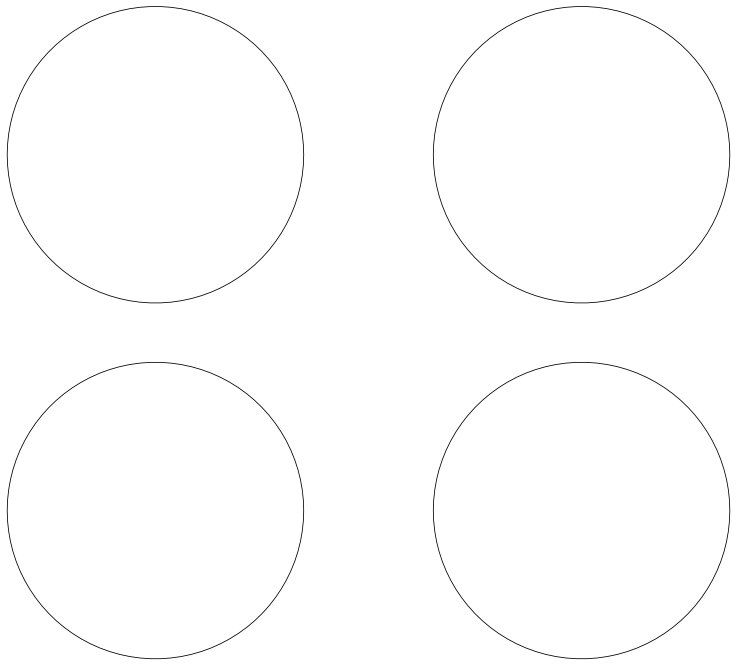

In [15]:
#Upload library that will give me access to CRS
import cartopy.crs as ccrs
#Upload library that contains shapefiles of terrestrial features
import cartopy.feature as cft

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Create an empty composite figure with 2 rows and 2 columns, set figure size and the projection is set to polar
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 12), subplot_kw = dict(projection = projection))
#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (1, 1, 'MAM'), (1, 0, 'JJA'), (0, 1, 'SON')]:
    #Extract information for each season and start plotting
    #pcolormesh creates a pseudo color map with a non-rectangular grid
    meanTempSeason.sel(season = season).plot.pcolormesh(
        x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], cmap = "Spectral_r", vmin = -10, vmax = 30, 
        ##Allows for a flat map centrered in longitude 0 - this is always needed when plotting a map with cartopy
        transform = ccrs.PlateCarree())
    #Set season as title for each subplot and remove x and y axes labels
    axes[i,j].set_title(season)
    axes[i,j].set_ylabel("")
    axes[i,j].set_xlabel("")

#Changing global parameters
for ax in axes.flat:
    #Set the extent of the maps and set the projection to polar
    ax.set_extent([-280, 80, -80, -40], crs = ccrs.PlateCarree())
    #Add the Antarctic continent
    ax.add_feature(land_50m, color = [0.8, 0.8, 0.8])
    #Adds outlines for the coast
    ax.coastlines(resolution = '50m')

#Removes white space
plt.tight_layout()
#Set title for composite figure
fig.suptitle('Mean seasonal water temperatures (top 10 m) between 2010 and 2011', fontsize = 16)

#Save figure to local folder
plt.savefig("meanTemp.tiff")

In [13]:
#Loading salinity data
salt_array = cc.querying.getvar(expt, salt_var, session, start_time = stime)
salt_array 

,Array,Chunk
Bytes,279.94 GB,3.36 MB
Shape,"(96, 75, 2700, 3600)","(1, 7, 300, 400)"
Count,171120 Tasks,85536 Chunks
Type,float32,numpy.ndarray


In [ ]:
#Loading ice area data
ice_array = cc.querying.getvar(expt, ice_var, session, start_time = stime)
ice_array 